In [25]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

def load_save_and_get_horizons(model_name,target_data,p,dataset_names):
    id_name = f"{target_data}_{model_name}.{'_'.join(dataset_names)}_{p}p"
    # folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',f'{target_data}_{p}p')
    folder_path = os.path.join(f'save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_{model_name}',id_name)

    results = pd.read_csv(f'{folder_path}/METRICS_{id_name}.csv',index_col = 0)

    mae_metrics = [c for c in results.columns if ('mae' in c) and (not 'VAR' in c) and not ('complete' in c)]
    mae_metrics  = [int(c.split('h')[-1]) for c in mae_metrics]
    horizon_max = int(np.max(np.array(mae_metrics)))
    return results,horizon_max


def plot_accuracy_according_size(model_names,dic_dataset_names,metrics,target_data,percentage_list,horizon_list = None):

    # == Init
    for model_name in model_names:
        for dataset_names in dic_dataset_names[model_name]:
            for metric in metrics:
                _,horizon_max = load_save_and_get_horizons(model_name,target_data,100,dataset_names)
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"] = []
                globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"] = []
    # ...

    for model_name in model_names:
        for dataset_names in dic_dataset_names[model_name]:
            #== Fill List: 
            for p in percentage_list:
                # build list of metrics for each percentage
                results,horizon_max = load_save_and_get_horizons(model_name,target_data,p,dataset_names)

                for metric in metrics:
                    selected_columns = [c for c in results.columns if (c.startswith(metric)) and not 'complete' in c]
                    metric_all = results[selected_columns].mean(axis=1)['test']
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"].append(metric_all)
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"].append(results[selected_columns][f"{metric}_h1"]['test'])
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"].append(results[selected_columns][f"{metric}_h{horizon_max//2}"]['test'])
                    globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"].append(results[selected_columns][f"{metric}_h{horizon_max}"]['test'])
                # ...
                
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h1"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h1"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max//2}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max//2}"] for metric in metrics})
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max}"] = pd.DataFrame({metric: globals()[f"{model_name}_{metric}_{'_'.join(dataset_names)}_list_h{horizon_max}"] for metric in metrics})

            globals()[f"df_{model_name}_{'_'.join(dataset_names)}"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h1"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max//2}"].index = percentage_list
            globals()[f"df_{model_name}_{'_'.join(dataset_names)}_h{horizon_max}"].index = percentage_list
            # ...

    if horizon_list is None:
        horizon_list = [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]

    
    for horizon in horizon_list:
        fig, axes = plt.subplots(1,len(metrics),figsize=(22, 5))
        for k,metric in enumerate(metrics): 
            for model_name in model_names:
                for dataset_names in dic_dataset_names[model_name]:
                    axes[k].plot(globals()[f"df_{model_name}_{'_'.join(dataset_names)}{horizon}"][metric].index,globals()[f"df_{model_name}_{'_'.join(dataset_names)}{horizon}"][metric],
                                 label = f"{model_name} - {'_'.join(dataset_names)} ")
            title = f"Comparison of {metric.upper()}\ between: {','.join(model_names)}\non {target_data} prediction\n"
            if horizon != '':
                title = f"{title}\n at horizon {horizon[2:]}"
            axes[k].set_title(title)
            axes[k].set_xlabel('Percentage total training data')
            axes[k].set_ylabel(metric.upper())
            #plt.xticks(range(len(percentage_list)), percentage_list)
            plt.ylabel(metric)
            plt.xlabel('Percentage of Training Data')
            plt.legend()
            if metric == 'mase':
                axes[k].plot([np.min(np.array(percentage_list)), 100], [1, 1], color='red', linestyle='--', label='MASE = 1')
        plt.show()

print('Current working directory: ',os.getcwd())

Current working directory:  /home/rrochas/prediction-validation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


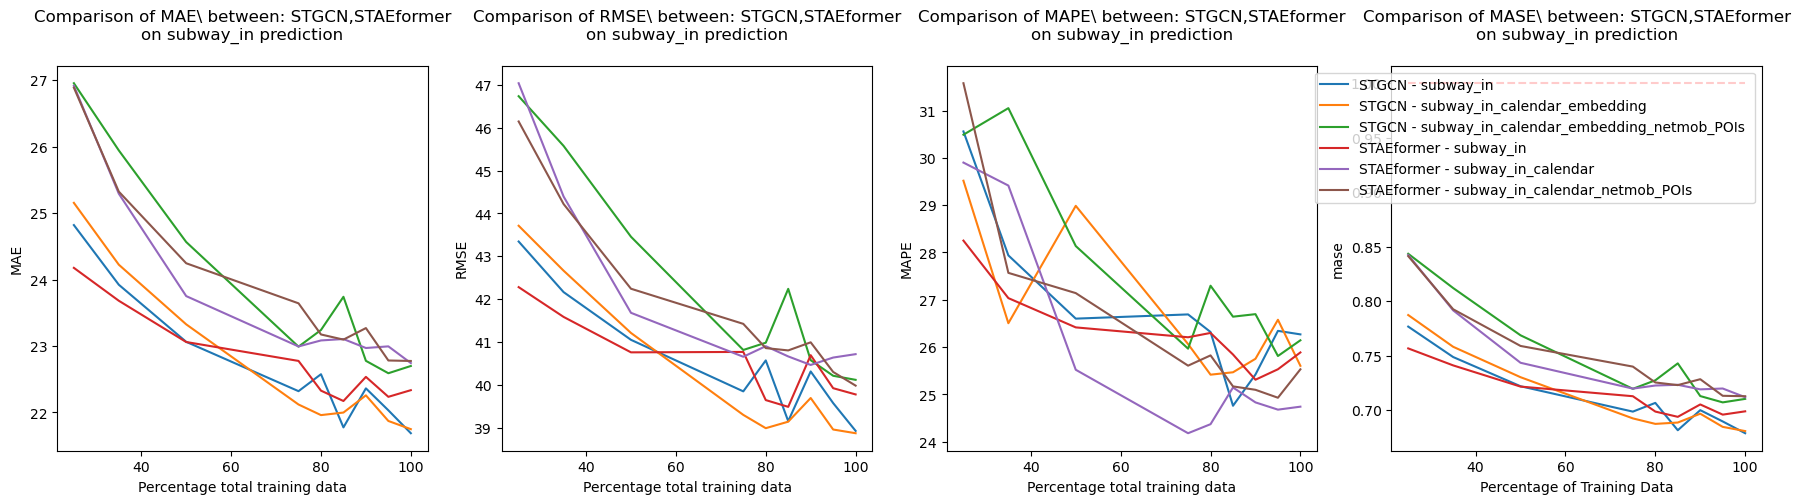

In [ ]:
# target_data = 'PeMS08_flow'
target_data  = 'subway_in'

metrics = ['mae','rmse','mape','mase']


dic_dataset_names = {'STAEformer':[['subway_in'],['subway_in','calendar'], ['subway_in','calendar','netmob_POIs']],
                    'STGCN':[['subway_in'], ['subway_in','calendar_embedding'],['subway_in', 'calendar_embedding','netmob_POIs']]
                    }

model_names = ['STGCN','STAEformer']

# percentage_list = [50,75,80,85,90,95,100]# [10,15,25,35,50,75,80,85,90,95,100] # [25,35,50,75,80,85,90,95,100]  
percentage_list = [25,35,50,75,80,85,90,95,100]  

horizon_list = ['']
# horizon_max = 4
# [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]

plot_accuracy_according_size(model_names,dic_dataset_names,metrics,target_data,percentage_list,horizon_list = horizon_list)

In [ ]:
os.listdir('save/K_fold_validation/training_wo_HP_tuning/comparison_accuracy_per_size_STGCN/subway_in_STGCN.subway_in_calendar_embedding_10p/METRICS_subway_in_STGCN')

['PeMS08_flow_10p',
 'PeMS08_flow_25p',
 'PeMS08_flow_15p',
 'PeMS08_flow_35p',
 'PeMS08_flow_50p',
 'PeMS08_flow_75p',
 'PeMS08_flow_100p',
 'PeMS08_flow_80p',
 'PeMS08_flow_85p',
 'PeMS08_flow_90p',
 'PeMS08_flow_95p',
 'subway_in_10p',
 'subway_in_15p',
 'subway_in_25p',
 'subway_in_35p',
 'subway_in_50p',
 'subway_in_75p',
 'subway_in_80p',
 'subway_in_85p',
 'subway_in_90p',
 'subway_in_95p',
 'subway_in_100p',
 'subway_in_STGCN.subway_in_10p',
 'subway_in_STGCN.subway_in_15p',
 'subway_in_STGCN.subway_in_25p',
 'subway_in_STGCN.subway_in_35p',
 'subway_in_STGCN.subway_in_50p',
 'subway_in_STGCN.subway_in_75p',
 'subway_in_STGCN.subway_in_80p',
 'subway_in_STGCN.subway_in_85p',
 'subway_in_STGCN.subway_in_90p',
 'subway_in_STGCN.subway_in_95p',
 'subway_in_STGCN.subway_in_100p',
 'subway_in_STGCN.subway_in_calendar_embedding_25p',
 'subway_in_STGCN.subway_in_calendar_embedding_35p',
 'subway_in_STGCN.subway_in_calendar_embedding_50p',
 'subway_in_STGCN.subway_in_calendar_embedding

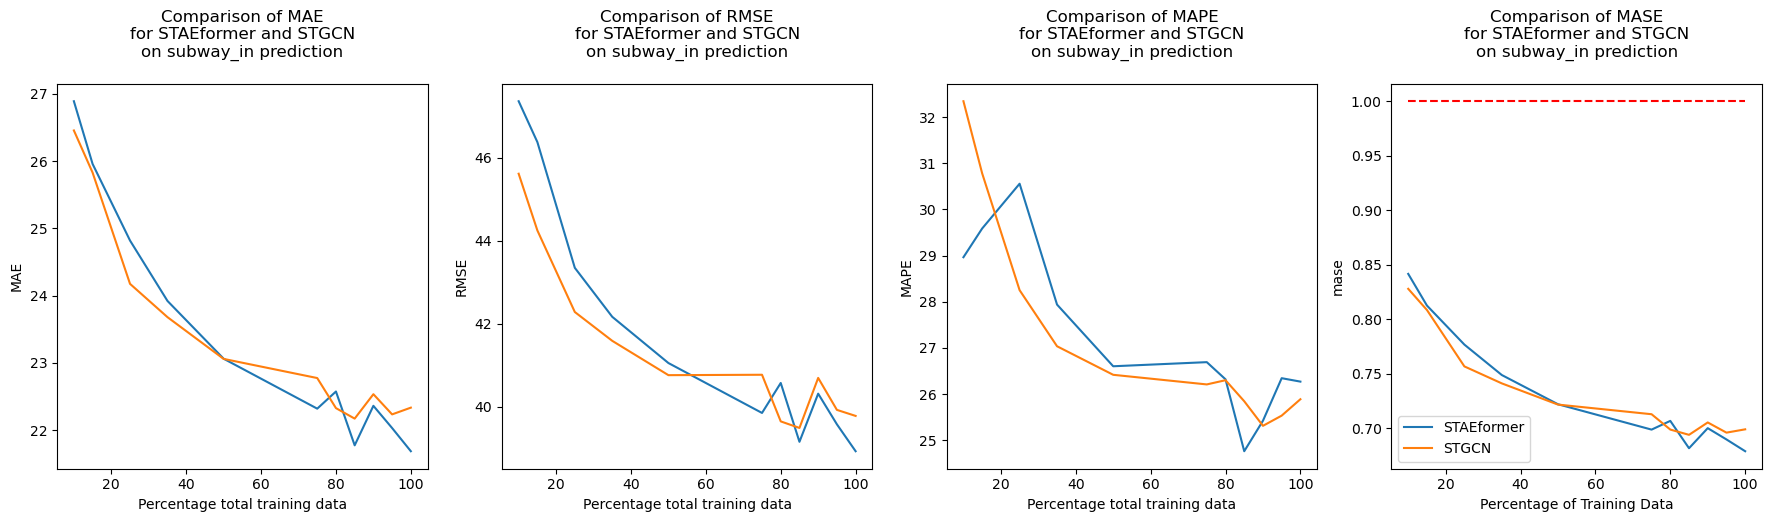

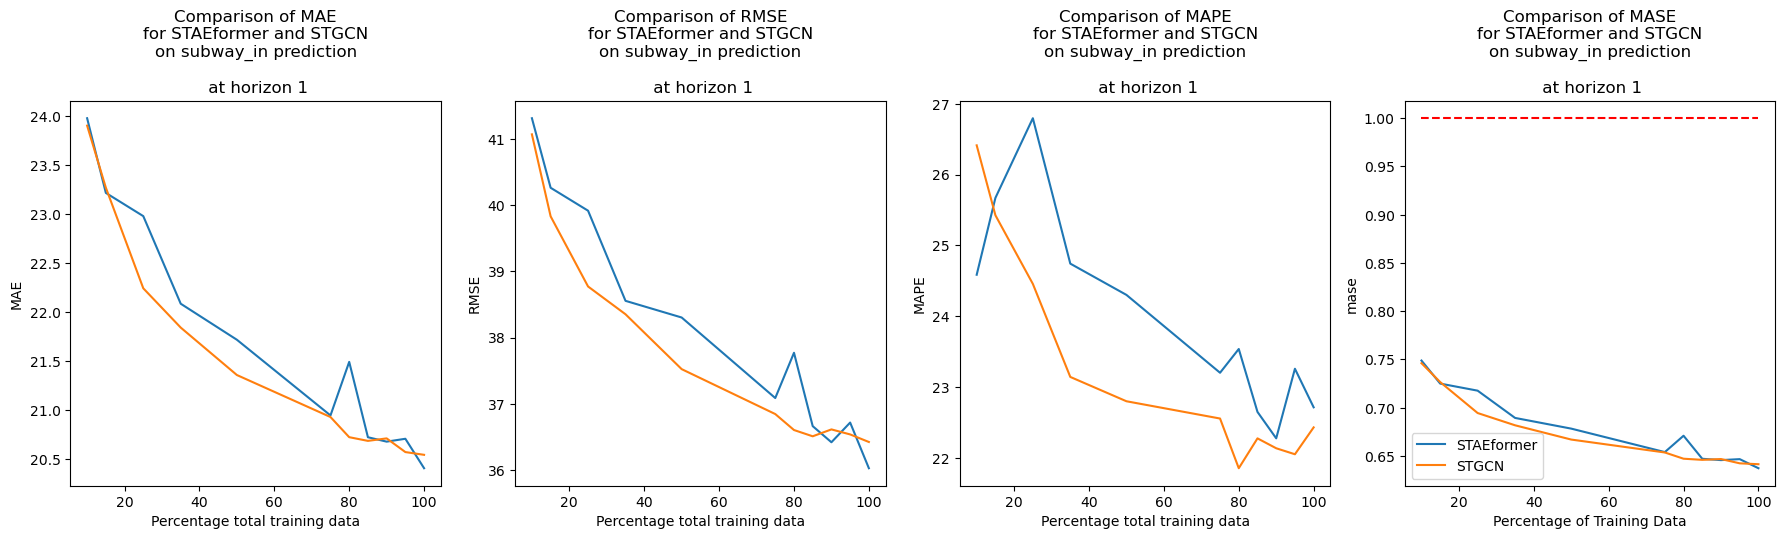

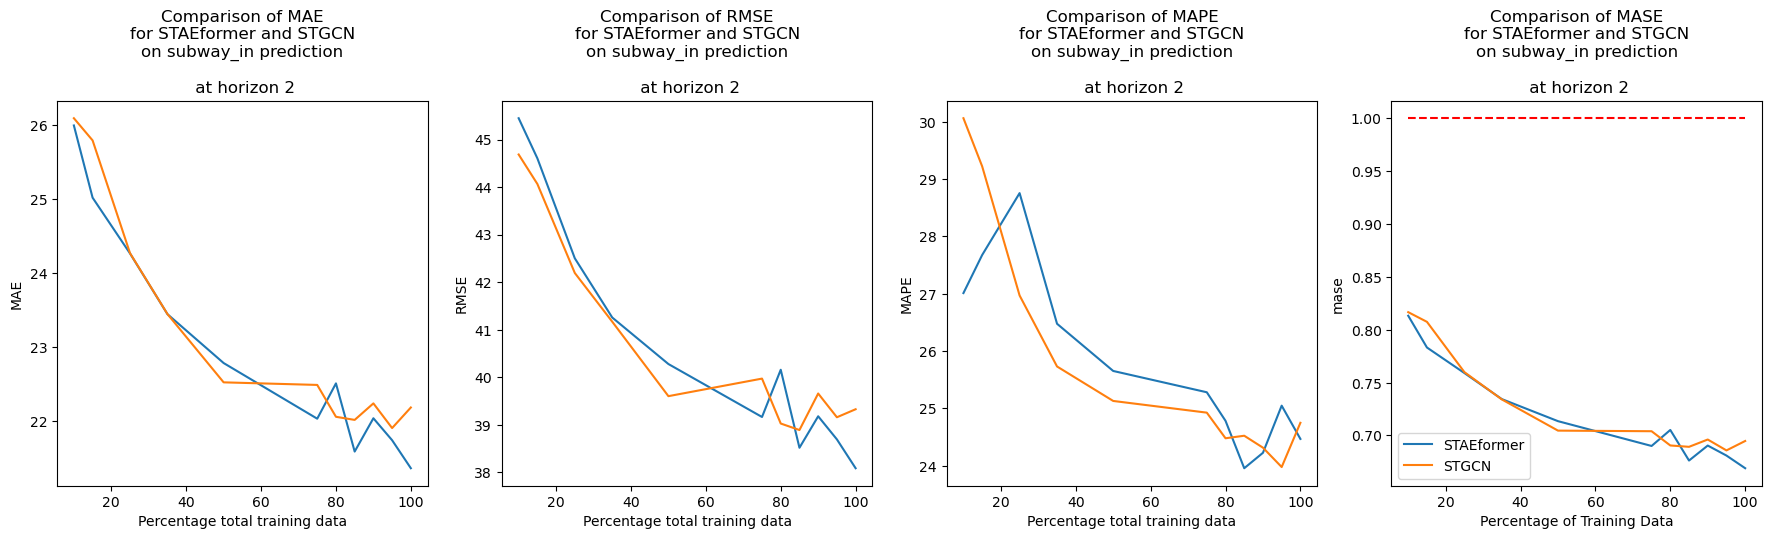

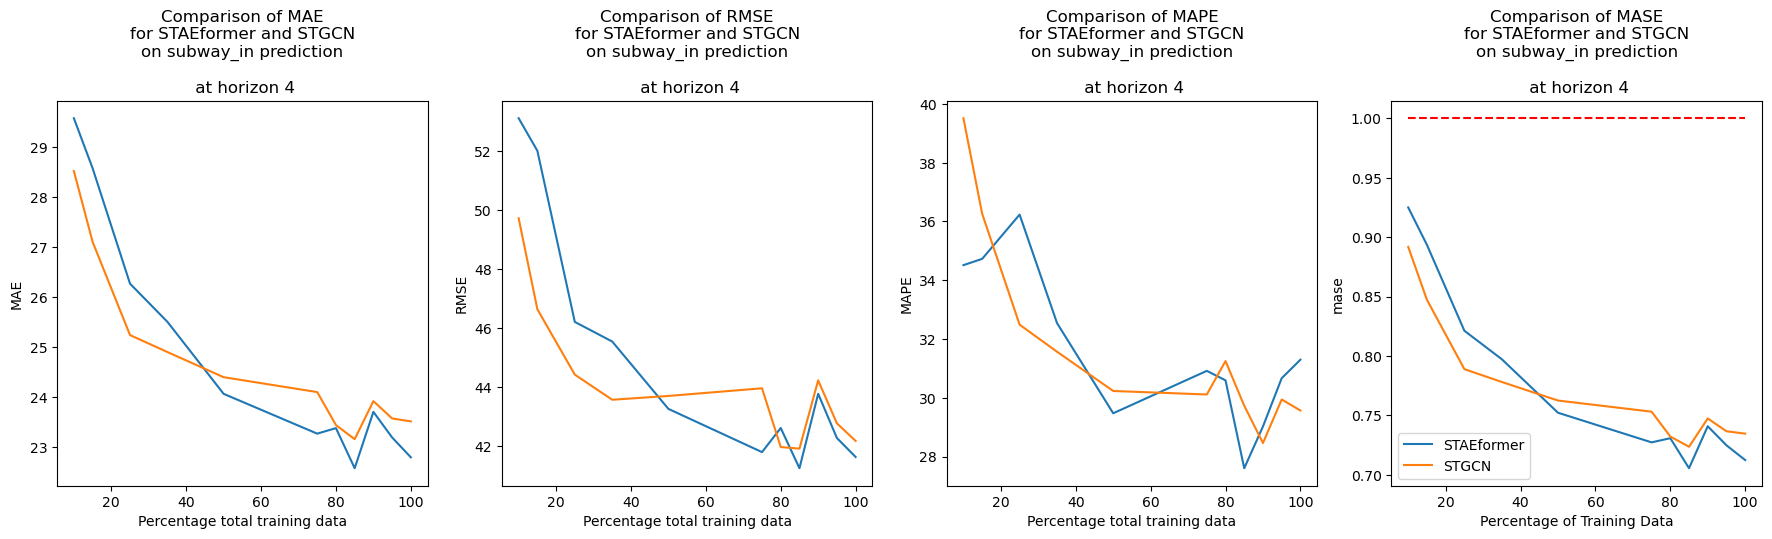

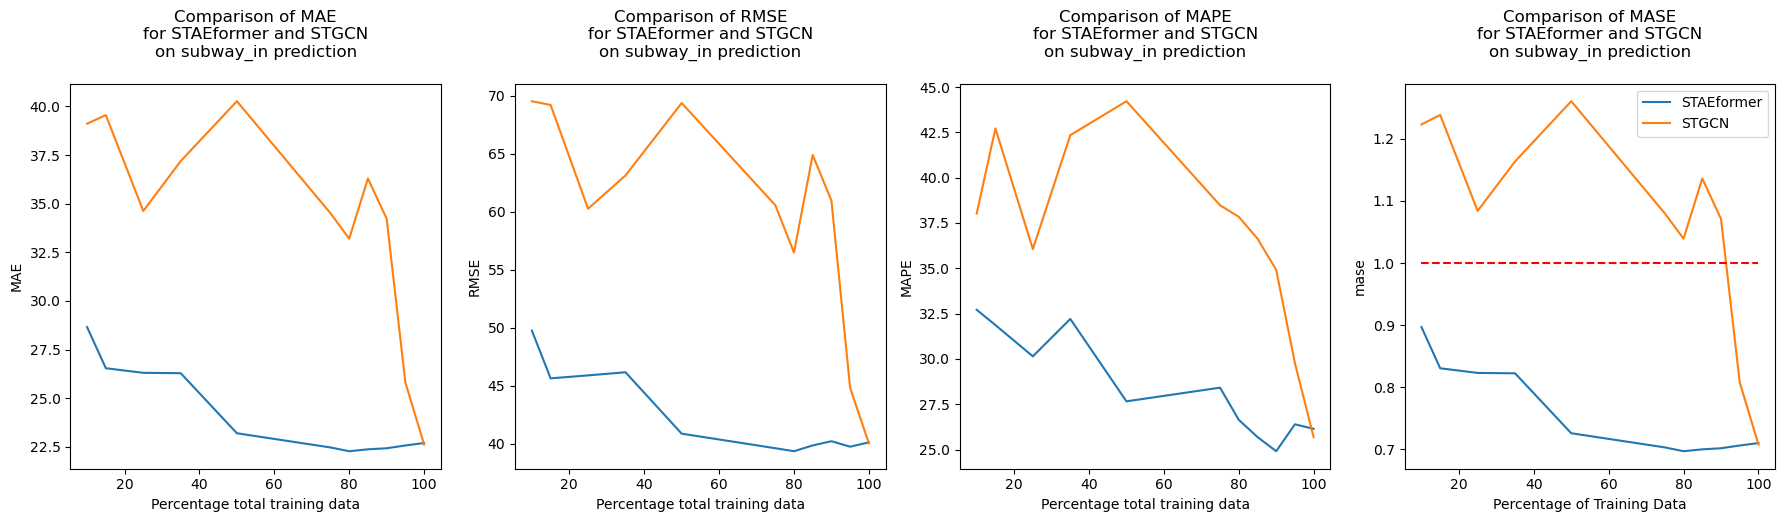

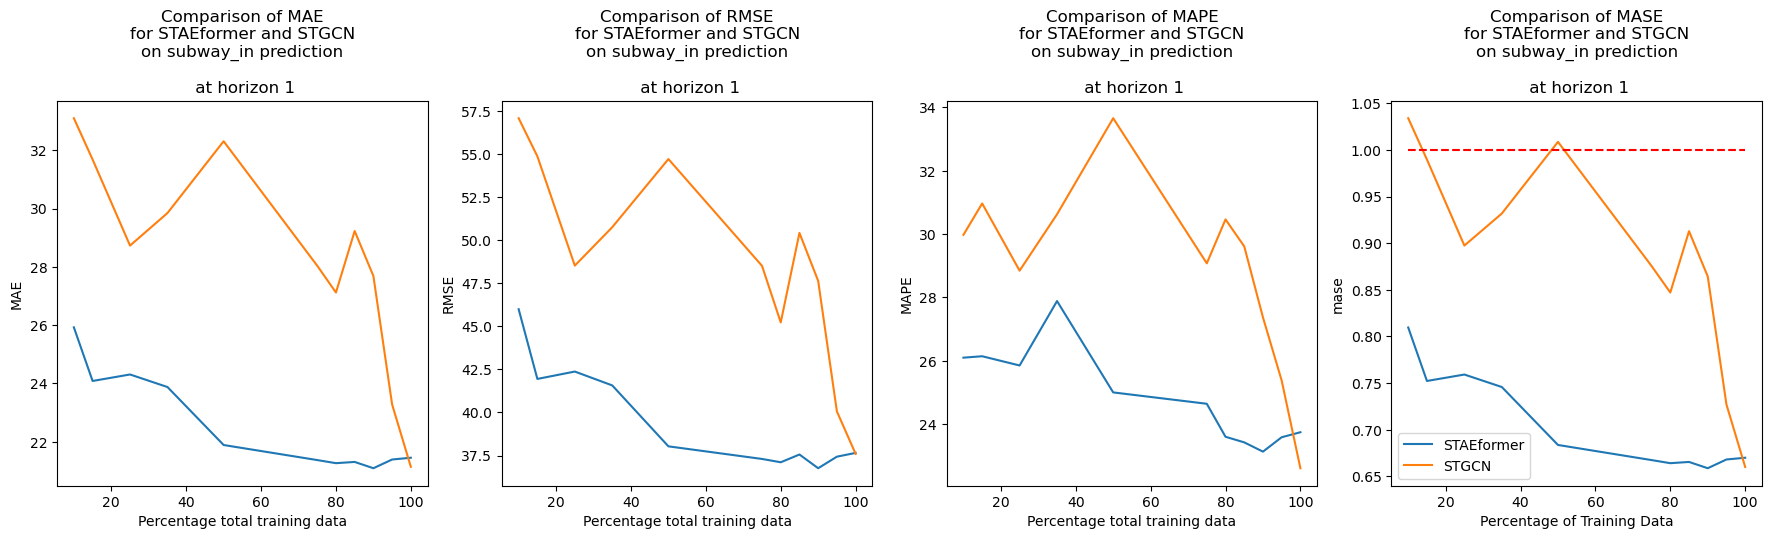

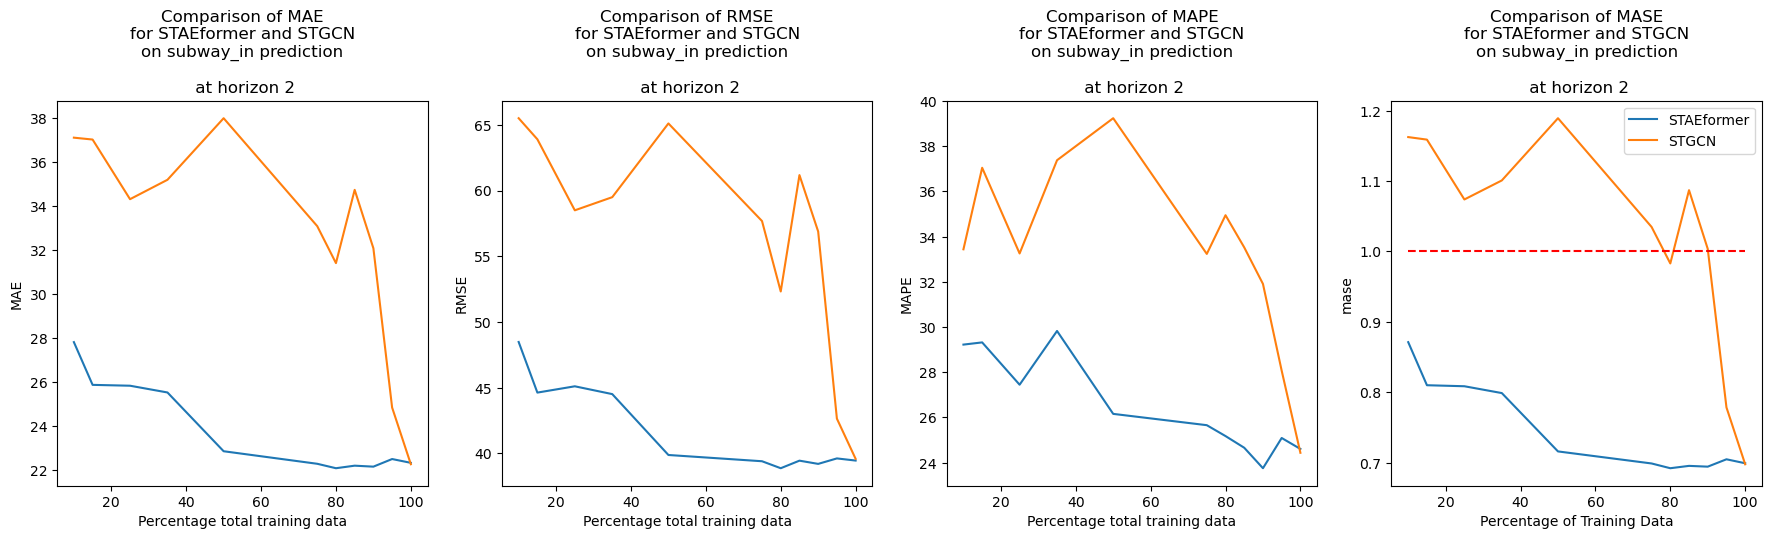

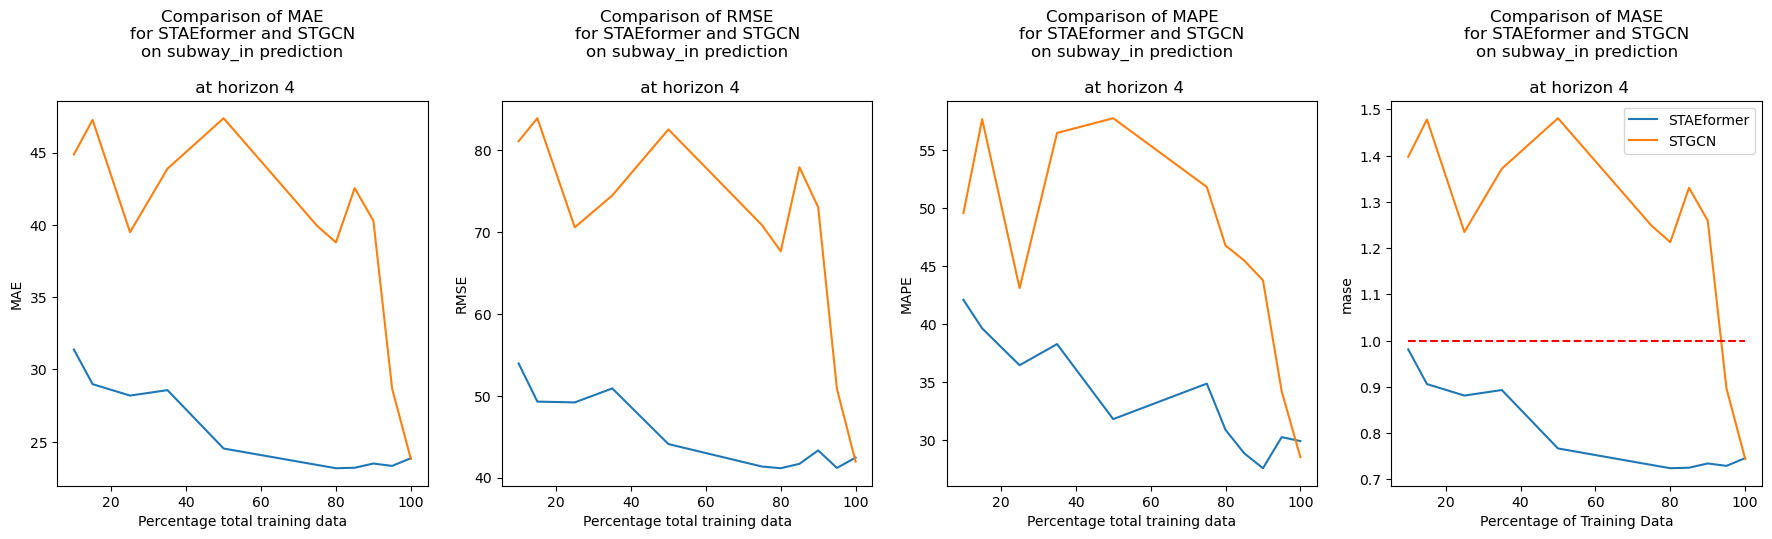

In [19]:
import matplotlib.pyplot as plt

for horizon in [''] + [f'_h{h}' for h in [1,horizon_max//2,horizon_max]]:
    fig, axes = plt.subplots(1,len(metrics),figsize=(22, 5))
    for k,metric in enumerate(metrics): 
        for model_name in ['STGCN','STAEformer']:
            axes[k].plot(globals()[f"df_{model_name}{horizon}"][metric].index,globals()[f"df_{model_name}{horizon}"][metric])
        title = f'Comparison of {metric.upper()}\nfor STAEformer and STGCN\non {target_data} prediction\n'
        if horizon != '':
            title = f"{title}\n at horizon {horizon[2:]}"
        axes[k].set_title(title)
        axes[k].set_xlabel('Percentage total training data')
        axes[k].set_ylabel(metric.upper())
        #plt.xticks(range(len(percentage_list)), percentage_list)
        plt.ylabel(metric)
        plt.xlabel('Percentage of Training Data')
        plt.legend(['STAEformer', 'STGCN'])
        if metric == 'mase':
            axes[k].plot([np.min(np.array(percentage_list)), 100], [1, 1], color='red', linestyle='--', label='MASE = 1')
    plt.show()